# Importações

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, classification_report

import warnings
warnings.filterwarnings('ignore')

# 1. Data Loading

In [2]:
df = pd.read_csv('/home/esdras-daniel/Documentos/Python/PGM-DataAnalysis/data/processed/pgm-dataset-processado.csv')
df.head(3)

,teorTexto,setorDestino,tipoAviso,orgaoJulgador,assuntos,documentos,anexos,classeProcesso
0,PODER JUDICIÁRIO ESTADO DO RIO GRANDE DO NORTE...,Saúde,Intimação,2ª VIJ da Com. Natal,12485;12494,Decisão;Petição de manifestação;Despacho;Certi...,notaTecnica-228951.pdf - notaTecnica-228951;E-...,1706
1,PODER JUDICIÁRIO DO ESTADO DO RIO GRANDE DO NO...,Administrativa,Intimação,3º JFP da Com. Natal,10715,Notificação;Petição;Despacho;Diligência;Notifi...,FICHA FINANCEIRA;SEMAD - Joelma;08464942120228...,14695
2,PODER JUDICIÁRIO DO ESTADO DO RIO GRANDE DO NO...,Fiscal,Intimação,5ª VEFT de Natal,9518,Despacho;Petição;Despacho;Petição;Despacho;Pet...,docs habilitação;Sisbajud Positivo;CÁLCULOS;Ex...,156


In [3]:
df['setorDestino'].value_counts(normalize=True)

setorDestino
Fiscal            0.437480
Administrativa    0.353530
Contabilidade     0.087548
Judicial          0.074396
Saúde             0.028986
Meio Ambiente     0.010142
Patrimonial       0.007917
Name: proportion, dtype: float64

## 1.1 - LabelEncoder

In [4]:
from sklearn.preprocessing import LabelEncoder

# Codifica os labels para garantir consistência ao longo de todos os classificadores
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df['setorDestino'])

Um problema que podemos observar nos nossos dados é o desbalanceamento entre classes. Para um problema de classificação isso pode resultar em um classificador "preguiçoso" onde prefere apenas classificar as classes predominantes.

Porém, apenas fazer upsampling e downsampling pode trazer problemas de *leakage*, onde dados que não deveriam ser vistos pelo modelo são utilizados acidentalmente para o treinamento.

A melhor abordagem é primeiro separa os dados de treinamento e teste de forma **estratificada** e só aplicar o upsampling nos dados de treinamento.

<h3>Passos da Solução</h3>

1. Dividir os dados entre treinamento e teste de forma estratificada
    * Isso garante que o conjunto de teste mantenha a proporção original das classes.

2. Aplicar o *upsampling* apenas no conjunto de treinamento
    * Pode ser feito duplicando amostras da classe minoritária ou usando técnicas como SMOTE (que cria amostras sintéticas).

3. Treinar o modelo na base balanceada e calidar no conjunto de teste original
    * Isso garante que a avaliação reflete o desempenho real do modelo.    

## 1.2 - Separação dos dados de forma estratificada

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded)
print(f'Shape dos dados de treinamento: {X_train.shape}')
print(f'Shape dos dados de teste: {X_test.shape}')

Shape dos dados de treinamento: (10698, 8)
Shape dos dados de teste: (4585, 8)


## 1.3 - *Upsampling* e *Downsampling* dos dados de treinamento.

In [6]:
def balance_df(df: pd.DataFrame, balance_on:list = 'setorDestino', n_samples:int = 500):
    unique_classes = df[balance_on].unique()
    
    dfs_list = []

    for classe in unique_classes:
        if len(df[df[balance_on] == classe]) >= n_samples:
            dfs_list.append(df[df[balance_on] == classe].sample(n=n_samples, replace=False))
        else:
            dfs_list.append(df[df[balance_on] == classe].sample(n=n_samples, replace=True))
    
    df_balanceado = pd.concat(dfs_list)

    return df_balanceado.sample(frac=1, replace=False)

X_train = balance_df(X_train, balance_on='setorDestino', n_samples=500)
y_train = label_encoder.transform(X_train['setorDestino'])

In [7]:
print(f'Shape dos dados de treinamento: {X_train.shape} | {y_train.shape}')

print(f'\n\nDISTRIBUIÇÃO DOS DADOS DE TREINAMENTO\n{X_train['setorDestino'].value_counts()}')
print(f'\n\nDISTRIBUIÇÃO DOS DADOS DE TESTE\n{X_test['setorDestino'].value_counts()}')



Shape dos dados de treinamento: (3500, 8) | (3500,)


DISTRIBUIÇÃO DOS DADOS DE TREINAMENTO
setorDestino
Fiscal            500
Patrimonial       500
Contabilidade     500
Meio Ambiente     500
Saúde             500
Administrativa    500
Judicial          500
Name: count, dtype: int64


DISTRIBUIÇÃO DOS DADOS DE TESTE
setorDestino
Fiscal            2006
Administrativa    1621
Contabilidade      401
Judicial           341
Saúde              133
Meio Ambiente       47
Patrimonial         36
Name: count, dtype: int64


# 2. Construção da Classe Classificador Final.

![Classificador Final](../img/Classificador_Ensemble.drawio.png)

## 2.1 - Criação dos Transformadores

In [8]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MultiLabelBinarizer
from typing import Tuple

# Transformador para a pipeline do sklearn

class ColumnExtractor(BaseEstimator, TransformerMixin):
    '''Transforma dados categóricos usando MultilabelBinarizer'''
    ''
    def __init__(self, col_name: str):
        
        self.col_name = col_name
        self.one_hot_encoding = MultiLabelBinarizer()

    def fit(self, X: pd.DataFrame, y=None):
        """Ajusta o MultiLabelBinarizer com os dados da coluna"""
        #if not isinstance(X, pd.DataFrame):
            #raise TypeError(f'Esperado um DataFrame, mas recebeu {type(X).__name__}.')
        
        # Verifica se a coluna existe no DataFrame
        #if self.col_name not in X.columns:
            #raise ValueError(f'A coluna {self.col_name} não foi encontrada no Dataframe.')
            
        # Ajusta o MultilabelBinarizer para as colunas categóricas
        
        # self.one_hot_encoding = MultiLabelBinarizer()
        #print(f'Inciando fit {self.col_name}')
        elements_list = X[self.col_name].fillna('').apply(lambda x: x.split(';') if isinstance(x, str) else [x])
        self.one_hot_encoding.fit(elements_list)

        return self
    
    def transform(self, X: pd.DataFrame):
        """Transforma os dados da coluna para one-hot encoding"""
        #if not isinstance(X, pd.DataFrame):
            #raise TypeError(f'Esperado um DataFrame, mas recebeu {type(X).__name__}.')
        
        # Faz o one-hot-encoding
        #if not self.one_hot_encoding:
            #raise ValueError(f'O MultiLabelBinarizer para "{self.col_name}" não foi treinado. Chame "fit" antes de "transform".')
            
        elements_list = X[self.col_name].fillna('').apply(lambda x: x.split(';') if isinstance(x, str) else [x])
        return self.one_hot_encoding.transform(elements_list)

class TfidfTransformer(BaseEstimator, TransformerMixin):
    '''Aplica TFIDF a uma coluna de textos'''

    def __init__(self, col_name):
        self.col_name = col_name
        self.tfidf = TfidfVectorizer(min_df=0.001, max_df=0.5, max_features=3000)

    def fit(self, X, y=None):
        #print('Iniciando fit TFIDF')
        self.tfidf.fit(X[self.col_name].fillna(''))
        return self
    
    def transform(self, X):
        return self.tfidf.transform(X[self.col_name].fillna(''))

# 3. Pipeline Final

Definição da Pipeline 'final' (falta o classificador de regras), onde temos, um classificador AdaBoost junto com um classificador Stacking

In [9]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier, StackingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression

# === Feature Transformations ===

tfidf_transformer = ('tfidf', TfidfTransformer(col_name='teorTexto'))
assuntos_transformer = ('assuntos_OHE', ColumnExtractor(col_name='assuntos'))
classe_processo_transformer = ('classeProcesso_OHE', ColumnExtractor(col_name='classeProcesso'))
orgao_julgador_transformer = ('orgaoJulgador_OHE', ColumnExtractor(col_name='orgaoJulgador'))

# Criando Feature Pipelines
feature_1 = FeatureUnion([assuntos_transformer, classe_processo_transformer, orgao_julgador_transformer])
feature_2 = FeatureUnion([tfidf_transformer, assuntos_transformer])
feature_3 = FeatureUnion([tfidf_transformer, assuntos_transformer, classe_processo_transformer, orgao_julgador_transformer])

# === Classifiers ===
# AdaBoost
clf_1 = Pipeline([
                ('feature_extraction', feature_1),
                ('classificator', AdaBoostClassifier(
                    estimator=LinearSVC(),
                    n_estimators=50,
                ))
            ])

# Stacking
stacking_estimators = [
    ('SVM', Pipeline([
        ('feature_extraction', feature_2),
        ('classificator', LinearSVC())
    ])),
    ('RF', Pipeline([
        ('feature_extraction', feature_3),
        ('classficator', RandomForestClassifier())
    ])),
    ('Logistic Regression', Pipeline([
        ('feature_extraction', feature_1),
        ('classificator', LogisticRegression())
    ]))
]

clf_2 = StackingClassifier(
    estimators=stacking_estimators,
    final_estimator=LogisticRegression(),
    cv = 10
)

final_model = VotingClassifier(estimators=[
    ('AdaBoost', clf_1),
    ('Stacking', clf_2)
], voting='hard')

In [10]:
final_model.fit(X_train, y_train)

VotingClassifier(estimators=[('AdaBoost',
                              Pipeline(steps=[('feature_extraction',
                                               FeatureUnion(transformer_list=[('assuntos_OHE',
                                                                               ColumnExtractor(col_name='assuntos')),
                                                                              ('classeProcesso_OHE',
                                                                               ColumnExtractor(col_name='classeProcesso')),
                                                                              ('orgaoJulgador_OHE',
                                                                               ColumnExtractor(col_name='orgaoJulgador'))])),
                                              ('classificator',
                                               AdaBoostClassifier(estimator=LinearS...
                                                              'Regression',
                                                              Pipeline(steps=[('feature_extraction',
                                                                               FeatureUnion(transformer_list=[('assuntos_OHE',
                                                                                                               ColumnExtractor(col_name='assuntos')),
                                                                                                              ('classeProcesso_OHE',
                                                                                                               ColumnExtractor(col_name='classeProcesso')),
                                                                                                              ('orgaoJulgador_OHE',
                                                                                                               ColumnExtractor(col_name='orgaoJulgador'))])),
                                                                              ('classificator',
                                                                               LogisticRegression())]))],
                                                 final_estimator=LogisticRegression()))])

# 4. Avaliando os modelos

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrices(final_model, X_test, y_test, labels):

    num_models = len(final_model.estimators_) + 1  # Número de subplots (modelos individuais + modelo final)
    num_cols = 2
    num_rows = int(np.ceil(num_models / num_cols))

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 6 * num_rows))
    axes = axes.flatten()

    # Loop pelos classificadores individuais
    for i, model in enumerate(final_model.estimators_):
        y_pred = model.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)

        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels, ax=axes[i])
        axes[i].set_title(f'Matriz de Confusão - {model.__class__.__name__}')
        axes[i].set_xlabel('Previsto')
        axes[i].set_ylabel('Real')

    # Matriz de confusão do modelo final (VotingClassifier)
    y_pred_final = final_model.predict(X_test)
    cm_final = confusion_matrix(y_test, y_pred_final)

    sns.heatmap(cm_final, annot=True, fmt="d", cmap="Reds", xticklabels=labels, yticklabels=labels, ax=axes[-1])
    axes[-1].set_title('Matriz de Confusão - Modelo Final')
    axes[-1].set_xlabel('Previsto')
    axes[-1].set_ylabel('Real')

    plt.tight_layout()
    plt.show()

## 4.1 - Avaliando o Voting Classifier e seus modelos.

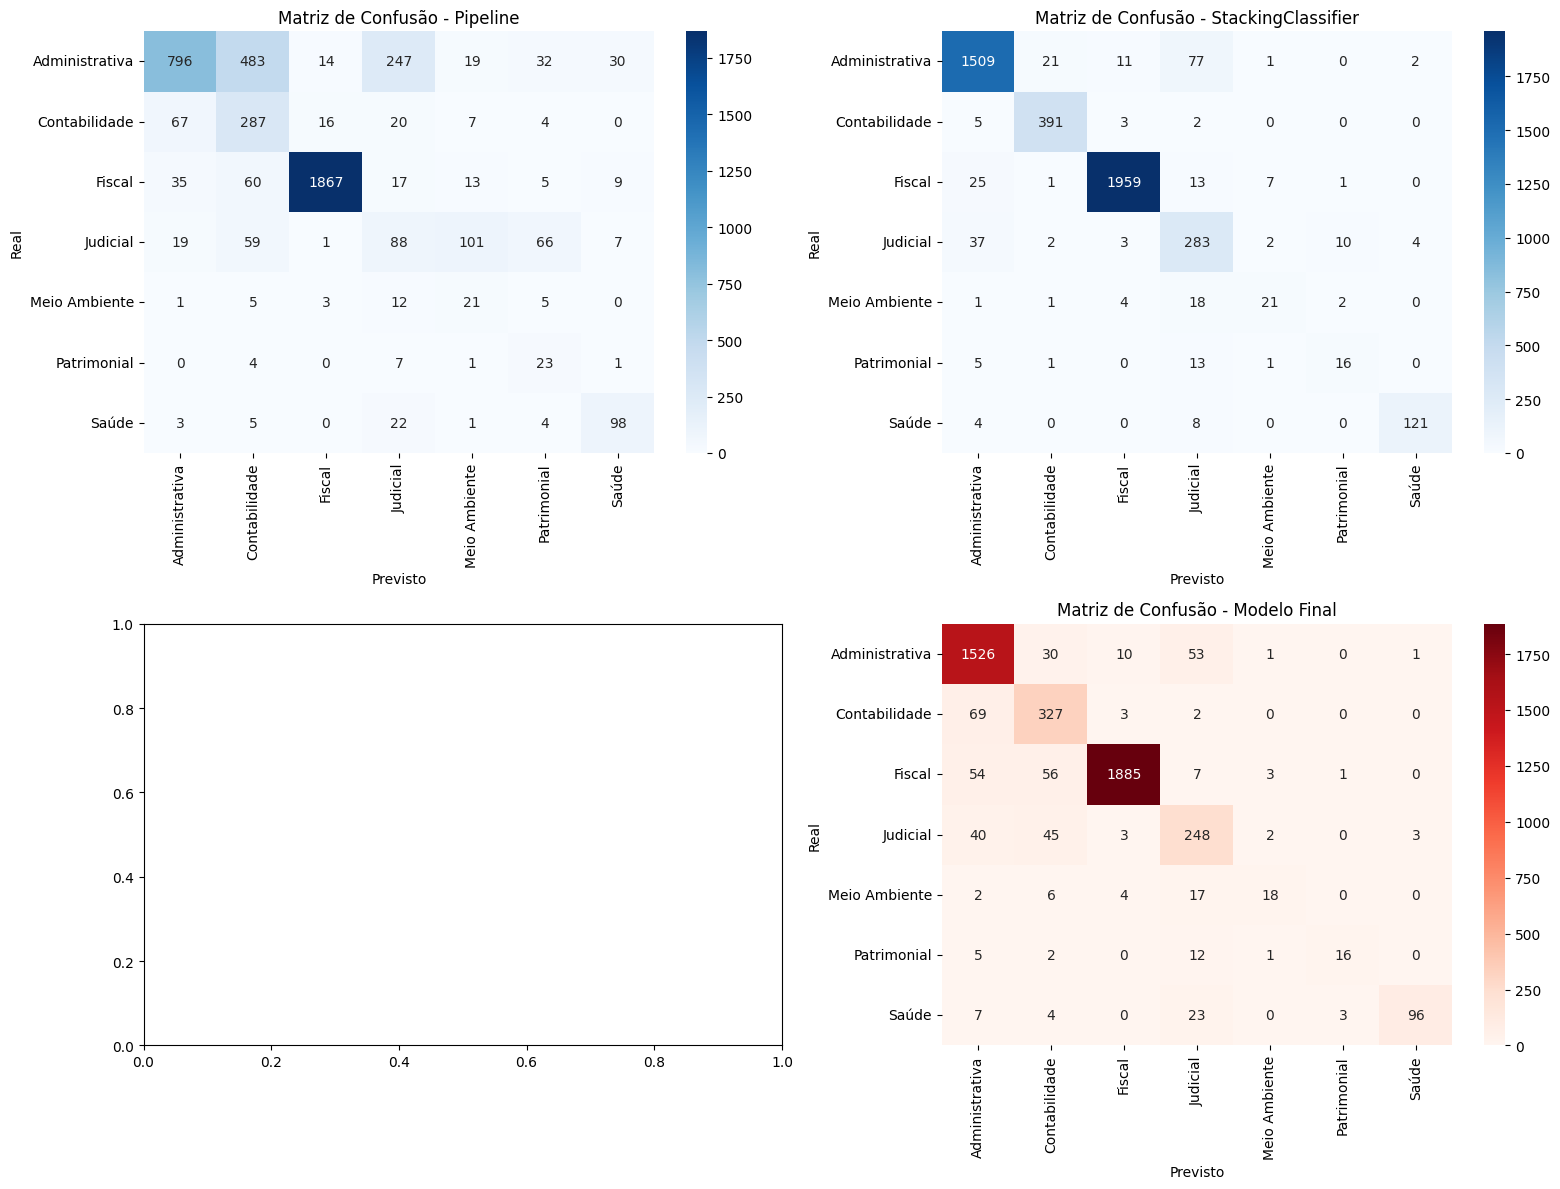

In [27]:
plot_confusion_matrices(final_model, X_test, y_test, labels=label_encoder.classes_)

In [ ]:
for i, estimator in enumerate(final_model.estimators_):
    print(f'Score {i+1}º estimador: {estimator.score(X_test, y_test)*100:.2f}%')
print(f'Score Voting Classifier: {final_model.score(X_test, y_test)*100:.2f}%')

Score 1º estimador: 69.36%
Score 2º estimador: 93.78%
Score Stacking Classifier: 89.77%


### 4.1.1 - Classification Report do modelo final e do StackingClassifier

In [41]:
y_pred_final_model = final_model.predict(X_test)
y_pred_stacking_model = final_model.estimators_[1].predict(X_test)

# Modelo Final
print(classification_report(y_test, y_pred_final_model, target_names=label_encoder.classes_, digits=4))

                precision    recall  f1-score   support

Administrativa     0.8961    0.9414    0.9182      1621
 Contabilidade     0.6957    0.8155    0.7509       401
        Fiscal     0.9895    0.9397    0.9639      2006
      Judicial     0.6851    0.7273    0.7055       341
 Meio Ambiente     0.7200    0.3830    0.5000        47
   Patrimonial     0.8000    0.4444    0.5714        36
         Saúde     0.9600    0.7218    0.8240       133

      accuracy                         0.8977      4585
     macro avg     0.8209    0.7104    0.7477      4585
  weighted avg     0.9030    0.8977    0.8980      4585



In [42]:
# Classificador Stack
print(classification_report(y_test, y_pred_stacking_model, target_names=label_encoder.classes_, digits=4))

                precision    recall  f1-score   support

Administrativa     0.9515    0.9309    0.9411      1621
 Contabilidade     0.9376    0.9751    0.9560       401
        Fiscal     0.9894    0.9766    0.9829      2006
      Judicial     0.6836    0.8299    0.7497       341
 Meio Ambiente     0.6562    0.4468    0.5316        47
   Patrimonial     0.5517    0.4444    0.4923        36
         Saúde     0.9528    0.9098    0.9308       133

      accuracy                         0.9378      4585
     macro avg     0.8175    0.7876    0.7978      4585
  weighted avg     0.9408    0.9378    0.9384      4585



Baseado na precisão e recall das 3 classes que tem maior incidência proponho utilizar o Classificador Stack, visto que o modelo final é consideravelmente melhor que o Stack apenas na classificação das classes com menor ocorrência

### 4.1.2 - Matriz de Confusão do Stacking Classifier e seu modelos

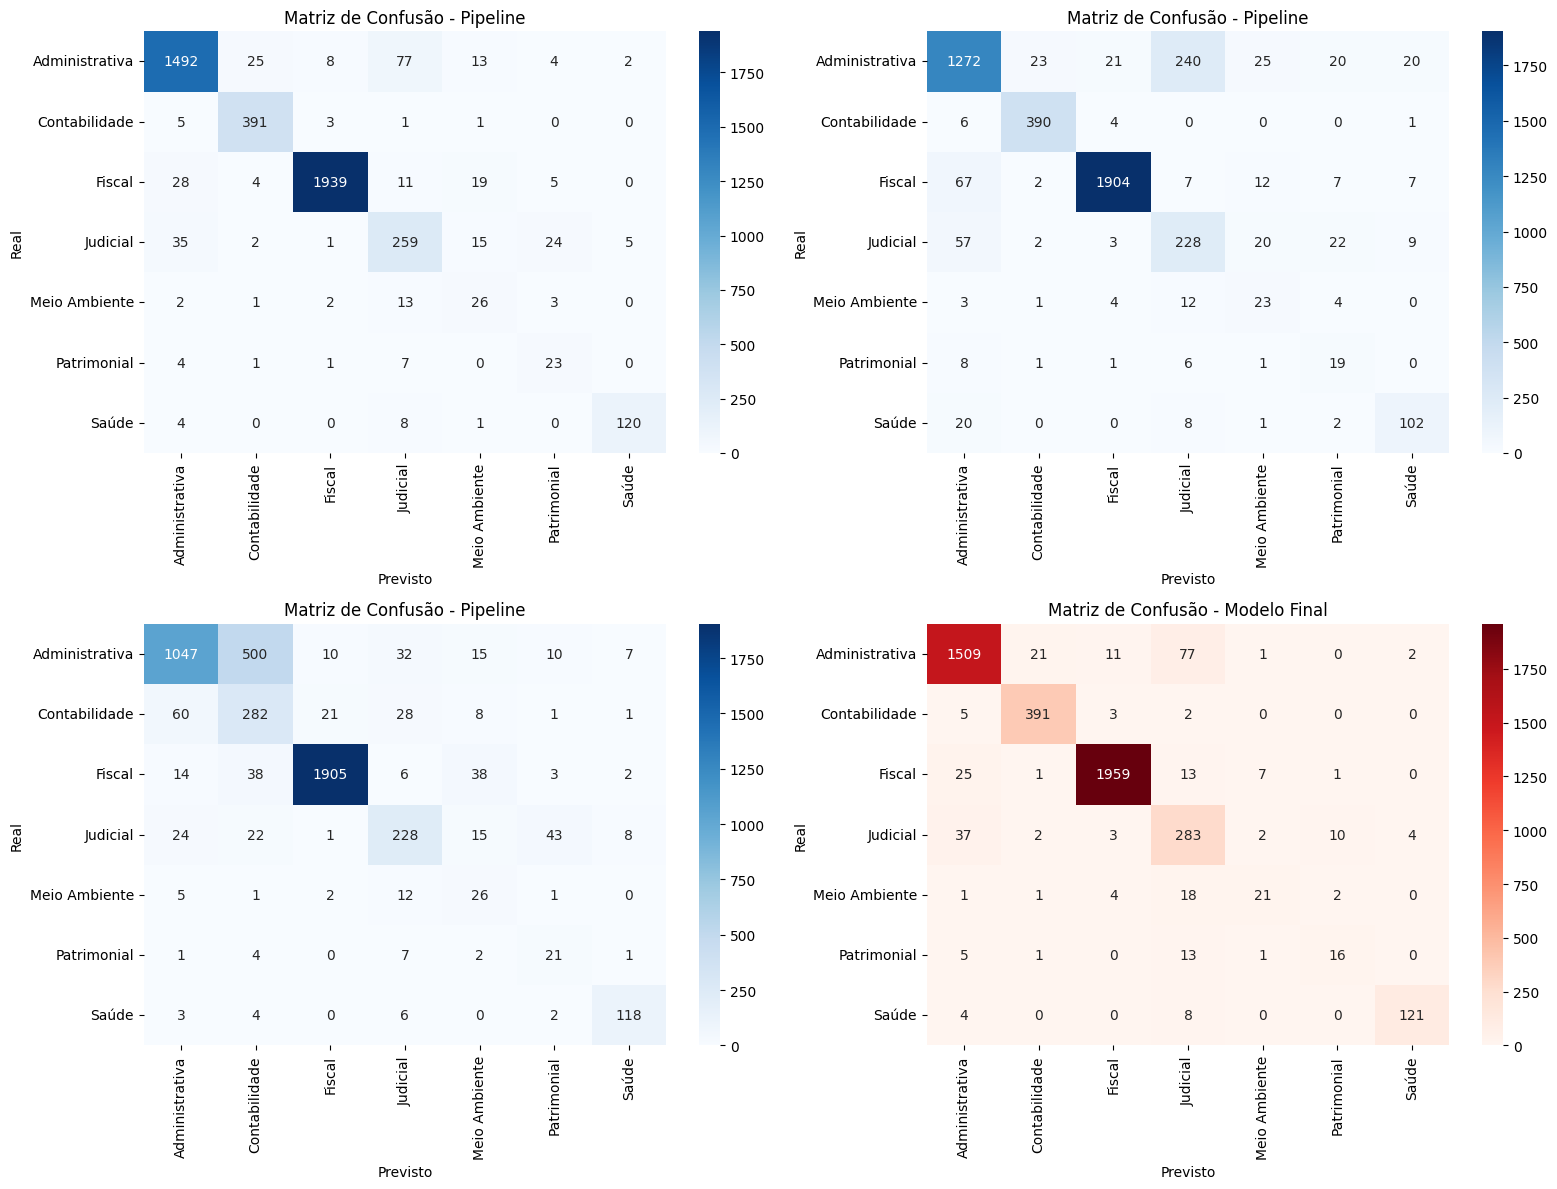

In [30]:
plot_confusion_matrices(final_model.estimators_[1], X_test, y_test, labels=label_encoder.classes_)

In [40]:
for i, estimator in enumerate(final_model.estimators_[1].estimators_):
    print(f'Score {i+1}º estimador: {estimator.score(X_test, y_test)*100:.2f}%')
print(f'Score Stacking Classifier: {final_model.estimators_[1].score(X_test, y_test)*100:.2f}%')

Score 1º estimador: 92.69%
Score 2º estimador: 85.89%
Score 3º estimador: 79.11%
Score Stacking Classifier: 93.78%
